<a href="https://colab.research.google.com/github/zemld/TimeseriesHSE/blob/main/algorithms_research/ARIMAX_with_finance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 19.8 MB/s eta 0:00:00


In [ ]:
!pip uninstall numpy -y
!pip install numpy==1.23.5

Found existing installation: numpy 1.23.5
Uninstalling numpy-1.23.5:
  Successfully uninstalled numpy-1.23.5
  Using cached numpy-1.23.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.3 kB)
Using cached numpy-1.23.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.1 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.23.5 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.23.5 which is incompatible.
albucore 0.0.23 requires numpy>=1.24.4, but you have numpy 1.23.5 which is incompatible.
blosc2 3.2.0 requires numpy>=1.26, but you have numpy 1.23.5 which is incompatible.
chex 0.1.89 requires numpy>=1.24.1, but you have numpy 1.23.5 which is incompatible.
jax 0.5.2 requires numpy>=1.25, but you have numpy 1.23.5 which is incompatible.
bigf

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from google.colab import files
import json

from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import StandardScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [ ]:
uploaded = files.upload()
# Чтение JSON-файла
df = pd.read_json(list(uploaded.keys())[0])

df.head()

Saving sber (1).json to sber (1) (1).json


,date,close,open,low,high,trendclspr,volume,value,numtrades
0,2022-03-28,125.00,130.60,125.00,131.47,-4.94,33212430,4.203875e+09,121793
1,2022-03-29,128.77,126.16,122.00,137.57,3.02,72338740,9.470337e+09,184608
2,2022-03-30,134.60,136.89,131.11,138.40,4.53,35675450,4.754054e+09,102479
3,2022-03-31,143.69,135.25,134.52,147.41,6.75,118425000,1.666945e+10,255603
4,2022-04-01,154.50,145.00,144.51,155.40,7.52,118880720,1.802233e+10,265276


In [ ]:
# На всякий случай сортируем
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date")

# Если в один день было несколько значений, то берем среднее
df = df.groupby("date", as_index=False).mean()
df = df.dropna()

# Создаём индексы без выходных
full_date_range = pd.date_range(df["date"].min(), df["date"].max(), freq="B")

df = df.set_index("date").reindex(full_date_range)

# Линейно интерполируем пропуски, если они вдруг есть
df = df.interpolate()

In [ ]:
def test_stationarity(series, title='Временной ряд'):
    print(f"Результаты теста Дики-Фуллера для: {title}")
    result = adfuller(series.dropna(), autolag='AIC')
    print(f"p-значение: {result[1]:.4f}")
    if result[1] > 0.05:
        print("Ряд нестационарен")
    else:
        print("Ряд стационарен")

test_stationarity(df['close'].dropna(), title='close')

Результаты теста Дики-Фуллера для: close
p-значение: 0.7545
Ряд нестационарен


In [ ]:
# Преобразуем ряд
df['close_diff'] = df['close'].diff()

# Проверим снова на стационарность
test_stationarity(df['close_diff'].dropna(), title='Дифференцированный close')

Результаты теста Дики-Фуллера для: Дифференцированный close
p-значение: 0.0000
Ряд стационарен


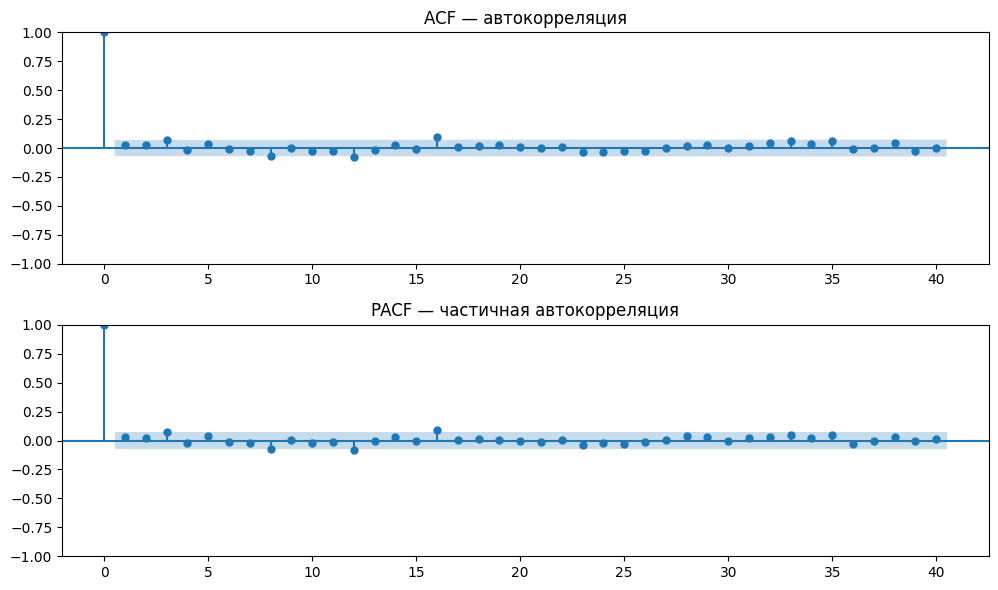

In [ ]:
# Оставим только нужный столбец
power_series = df['close_diff'].dropna()

# Строим ACF и PACF
fig, axes = plt.subplots(2, 1, figsize=(10, 6))

plot_acf(power_series, lags=40, ax=axes[0], title='ACF — автокорреляция')
plot_pacf(power_series, lags=40, ax=axes[1], title='PACF — частичная автокорреляция')

plt.tight_layout()
plt.show()

In [ ]:
# Целевой ряд
target = df["close"]
exog_features = ["open"]
exog = df[exog_features]

# Нормализуем
scaler = StandardScaler()
exog_scaled = pd.DataFrame(scaler.fit_transform(exog), index=exog.index, columns=exog.columns)

In [ ]:
train_target = target[:-10]
test_target = target[-10:]

train_exog = exog_scaled[:-10]
test_exog = exog_scaled[-10:]

In [ ]:
model = SARIMAX(train_target,
                exog=train_exog,
                order=(1, 1, 1),
                enforce_stationarity=False,
                enforce_invertibility=False)

results = model.fit(disp=False)

forecast = results.forecast(steps=10, exog=test_exog)

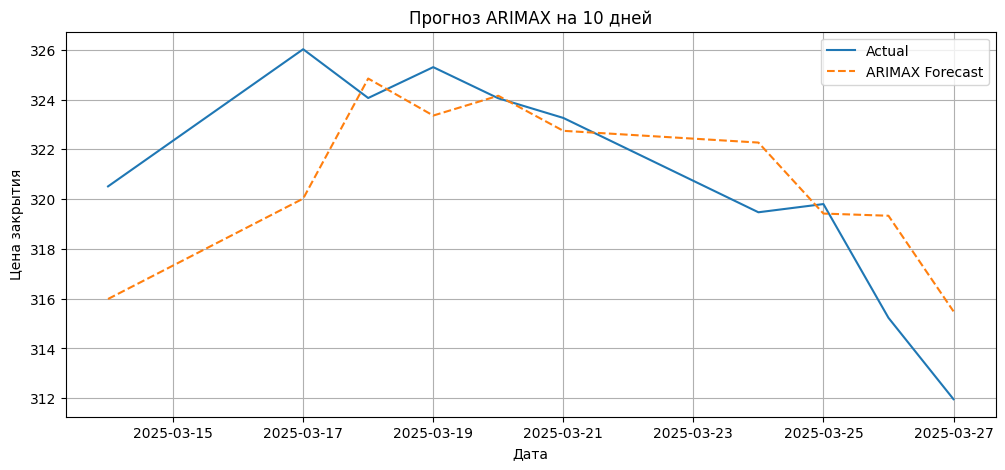

In [ ]:
forecast_series = pd.Series(forecast, index=test_target.index)

plt.figure(figsize=(12, 5))
plt.plot(test_target.index, test_target.values, label="Actual")
plt.plot(forecast_series.index, forecast_series.values, label="ARIMAX Forecast", linestyle="--")
plt.title("Прогноз ARIMAX на 10 дней")
plt.xlabel('Дата')
plt.ylabel('Цена закрытия')
plt.legend()
plt.grid()
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_true = test_target.values
y_pred = forecast_series.values
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mape = np.mean(np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), 1e-8))) * 100

print(f"MAE  = {mae:.4f}")
print(f"RMSE = {rmse:.4f}")
print(f"MAPE = {mape:.2f}%")

MAE  = 2.4030
RMSE = 2.9432
MAPE = 0.75%
